In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [162]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.svm import LinearSVC, SVC, OneClassSVM
from sklearn.cluster import DBSCAN, KMeans
from sklearn.mixture import BayesianGaussianMixture
from sklearn.neighbors import LocalOutlierFactor

In [4]:
file = pd.read_csv(r'Dataset/Dataset_13.05.2020_11.18am_1.csv')
tweets = np.asarray(file['Tweet'].copy())
targets = np.asarray(file['Is_Unreliable'].copy())
tweet_embeddings = np.load(r'Dataset/Tweet_Embeddings_Word2Vec_13.05.2020_2.41pm_1.npy', allow_pickle=True)
print(tweet_embeddings.shape)
print(tweet_embeddings[0].shape)
X = list()
for tweet in tweet_embeddings:
    embeddings = np.mean(tweet, axis=0, dtype=np.float64)
    X.append(embeddings)
X = np.asarray(X)
print(X.shape)
print(X.dtype)

y = targets
print(y.shape)
print(y.dtype)

(560,)
(15, 300)
(560, 300)
float64
(560,)
int64


In [189]:
# print(y)
# y[y == 1] = -1
# y[y == 0] = 1
# y[y == -1] = 0
# print(y)

In [98]:
class AE(nn.Module):

    def __init__(self, hidden_size=100):
        super(AE, self).__init__()
        self.fc1 = nn.Linear(300, hidden_size)  # 6*6 from image dimension
        self.fc2 = nn.Linear(hidden_size, 300)

    def forward(self, x):
#         x = torch.relu(self.fc1(x))
        x = self.fc1(x)
        x = self.fc2(x)
        return x

# net = AE()
# print(net)

def train_AE(model, X_train, y_train, X_test, y_test, epochs=100, to_print=False, print_interval=100):
    # define the optimization
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    train_mse_list, test_1_mse_list, test_0_mse_list = list(), list(), list()
    # enumerate epochs
    for epoch in tqdm(range(epochs)):
        # clear the gradients
        optimizer.zero_grad()
        X_train = torch.from_numpy(X_train).float()
        X_test = torch.from_numpy(X_test).float()
        output = model(X_train)
#         print(X_train)
#         print(output)
        train_loss = criterion(output, X_train)
        train_loss.backward()
        optimizer.step()
        if to_print and epoch%print_interval == 0:
            print("epoch : {}/{}, train_loss = {:.6f}".format(epoch + 1, epochs, train_loss))
        
        train_preds = model(X_train)
        X_train = X_train.numpy()
        train_preds = train_preds.detach().numpy()
        test_preds = model(X_test)
        X_test = X_test.numpy()
        test_preds = test_preds.detach().numpy()
        train_mse = np.mean(np.square(X_train - train_preds), axis=1)
        test_1_mse = np.mean(np.square(X_test[y_test == 1] - test_preds[y_test == 1]), axis=1)
        test_0_mse = np.mean(np.square(X_test[y_test == 0] - test_preds[y_test == 0]), axis=1)
        train_mse_list.append(train_mse), test_1_mse_list.append(test_1_mse), test_0_mse_list.append(test_0_mse)
#         print('Train:', train_mse, ' Test (1_class):', test_1_mse, ' Test (0_class):', test_0_mse)
        
    return model, (train_mse_list, test_1_mse_list, test_0_mse_list)

def train_AE_wo_tqdm(model, X_train, y_train, X_test, y_test, epochs=100, to_print=False, print_interval=100):
    # training without the tqdm bar
    
    # define the optimization
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    train_mse_list, test_1_mse_list, test_0_mse_list = list(), list(), list()
    # enumerate epochs
    for epoch in range(epochs):
        # clear the gradients
        optimizer.zero_grad()
        X_train = torch.from_numpy(X_train).float()
        X_test = torch.from_numpy(X_test).float()
        output = model(X_train)
#         print(X_train)
#         print(output)
        train_loss = criterion(output, X_train)
        train_loss.backward()
        optimizer.step()
        if to_print and epoch%print_interval == 0:
            print("epoch : {}/{}, train_loss = {:.6f}".format(epoch + 1, epochs, train_loss))
        
        train_preds = model(X_train)
        X_train = X_train.numpy()
        train_preds = train_preds.detach().numpy()
        test_preds = model(X_test)
        X_test = X_test.numpy()
        test_preds = test_preds.detach().numpy()
        train_mse = np.mean(np.square(X_train - train_preds), axis=1)
        test_1_mse = np.mean(np.square(X_test[y_test == 1] - test_preds[y_test == 1]), axis=1)
        test_0_mse = np.mean(np.square(X_test[y_test == 0] - test_preds[y_test == 0]), axis=1)
        train_mse_list.append(train_mse), test_1_mse_list.append(test_1_mse), test_0_mse_list.append(test_0_mse)
#         print('Train:', train_mse, ' Test (1_class):', test_1_mse, ' Test (0_class):', test_0_mse)
        
    return model, (train_mse_list, test_1_mse_list, test_0_mse_list)

def predict_AE(model, X_train, X_test, threshold, above_thres_class=0):
    
    X_train = torch.from_numpy(X_train).float()
    X_test = torch.from_numpy(X_test).float()
    train_out = model(X_train)
    X_train = X_train.numpy()
    train_out = train_out.detach().numpy()
    test_out = model(X_test)
    X_test = X_test.numpy()
    test_out = test_out.detach().numpy()
    train_mse = np.mean(np.square(X_train - train_out), axis=1)
    test_mse = np.mean(np.square(X_test - test_out), axis=1)
    
    train_preds, test_preds = np.empty((train_mse.shape[0])), np.empty((test_mse.shape[0]))
    train_preds[train_mse > threshold] = above_thres_class
    train_preds[train_mse <= threshold] = (above_thres_class+1)%2
    test_preds[test_mse > threshold] = above_thres_class
    test_preds[test_mse <= threshold] = (above_thres_class+1)%2
        
    return (train_preds, test_preds)

def predict_AE_for_ROC(model, X_train, X_test):
    
    X_train = torch.from_numpy(X_train).float()
    X_test = torch.from_numpy(X_test).float()
    train_out = model(X_train)
    X_train = X_train.numpy()
    train_out = train_out.detach().numpy()
    test_out = model(X_test)
    X_test = X_test.numpy()
    test_out = test_out.detach().numpy()
    train_mse = np.mean(np.square(X_train - train_out), axis=1)
    test_mse = np.mean(np.square(X_test - test_out), axis=1)
    
    return (train_mse, test_mse)

def predict_middle_layer_AE(model, X_train, X_test):
    
    train_out = model.fc1(torch.from_numpy(X_train).float())
    train_out = train_out.detach().numpy()
    test_out = model.fc1(torch.from_numpy(X_test).float())
    test_out = test_out.detach().numpy()
    
    return (train_out, test_out)

In [110]:
# from scipy import stats

# stats.describe(X)

In [6]:
# model = AE(hidden_size=100)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# optimizer.zero_grad()
# X_trial = X.copy()
# X_trial = torch.from_numpy(X_trial).float()
# output = model(X_trial)
# output = output.detach().numpy()

# # stats.describe(output)

In [65]:
# np.square(X_trial[0] - output[0])
# output[0]
# X_trial[0]


# _, _ = train_AE_wo_tqdm(model, X_train, y_train, X_test, y_test, to_print=False, epochs=10, print_interval=10)
# print(model.fc1.weight)
# print(optimizer)

In [64]:
# output = model(torch.from_numpy(X_train).float())
# output = output.detach().numpy()
# print(X_train.shape)
# print(output.shape)
# output_mse = np.mean(np.square(X_train - output), axis=1)
# print(np.mean(output_mse))
# # print(output_mse)

# output_2 = torch.relu(model.fc1(torch.from_numpy(X_train).float()))
# output_2 = model.fc2(output_2)
# output_2 = output_2.detach().numpy()
# print(X_train.shape)
# print(output_2.shape)
# output_2_mse = np.mean(np.square(X_train - output_2), axis=1)
# print(np.mean(output_2_mse))

In [99]:
percent = 0.9

X_0, X_1_, y_0, y_1_ = X[y==0].copy(), X[y==1].copy(), y[y==0].copy(), y[y==1].copy()
X_1, _, y_1, _ = train_test_split(X_1_, y_1_, train_size=percent, shuffle=True, random_state=0)

X_train, X_test_, y_train, y_test_ = train_test_split(X_0, y_0, train_size = 0.67, shuffle=True, random_state=0)
X_test, y_test = np.concatenate((X_1.copy(), X_test_.copy())), np.concatenate((y_1.copy(), y_test_.copy()))
X_test, y_test = shuffle(X_test, y_test, random_state=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AE(hidden_size=100).to(device)
n_epochs = 100
model, (train_mse_list, test_1_mse_list, test_0_mse_list) = train_AE(model, X_train, y_train, X_test, y_test, to_print=False, epochs=n_epochs, print_interval=n_epochs/10)

(train_mid_layer, test_mid_layer) = predict_middle_layer_AE(model, X_train, X_test)

100%|██████████| 100/100 [00:00<00:00, 161.54it/s]


In [100]:
test_mid_layer.shape

(345, 100)

0.5492404847243557
[[ 80  13]
 [225  27]]


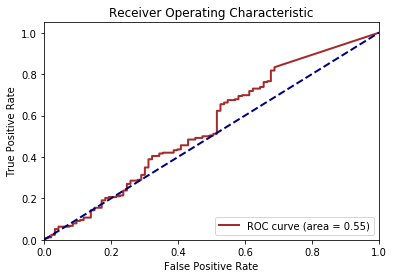

In [160]:
clustering = LocalOutlierFactor(novelty=True)

best_roc_auc, best_fpr, best_tpr = 0, _, _
for n_n in (1, 3, 5, 8, 10, 13, 15, 20, 30):
    for l_s in (10, 20, 30, 40, 50):
        c_now = LocalOutlierFactor(novelty=True, n_neighbors=n_n, leaf_size=l_s)
        c_now.fit(train_mid_layer)
        c_test_vals = c_now.decision_function(test_mid_layer)
#         c_test_vals = np.amin(c_now.kneighbors(test_mid_layer, return_distance=True)[0], axis=1)
        roc_auc_till_now = roc_auc_score(y_test, max(c_test_vals) - c_test_vals)
        if (roc_auc_till_now > best_roc_auc):
            best_roc_auc = roc_auc_till_now
            best_fpr, best_tpr, _ = roc_curve(y_test, max(c_test_vals) - c_test_vals, pos_label=1)
            best_roc_auc = auc(best_fpr, best_tpr)
            clustering = c_now

# clustering.fit(train_mid_layer)

cluster_test_preds = clustering.predict(test_mid_layer)
cluster_test_preds[cluster_test_preds == 1] = 0
cluster_test_preds[cluster_test_preds == -1] = 1

print(best_roc_auc)
print(confusion_matrix(y_test, cluster_test_preds))

plt.figure()
plt.plot(best_fpr, best_tpr, color='brown', lw=2, label='ROC curve (area = %0.2f)' % best_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

0.5168757467144565


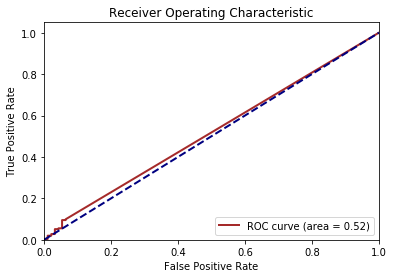

In [203]:
clustering = BayesianGaussianMixture(random_state=0, n_components=100)

best_roc_auc, best_fpr, best_tpr = 0, _, _
for w in np.arange(0.001, 0.015, 0.001):
    c_now = BayesianGaussianMixture(random_state=0, n_components=100)
    c_now.fit(train_mid_layer)
    c_test_vals = c_now.predict_proba(test_mid_layer)
    c_test_vals = np.amax(c_test_vals[:,(c_now.weights_ > w)], axis=1)
    roc_auc_till_now = roc_auc_score(y_test, max(c_test_vals) - c_test_vals)
    if (roc_auc_till_now > best_roc_auc):
        best_roc_auc = roc_auc_till_now
        best_fpr, best_tpr, _ = roc_curve(y_test, max(c_test_vals) - c_test_vals, pos_label=1)
        best_roc_auc = auc(best_fpr, best_tpr)
        clustering = c_now

# clustering.fit(train_mid_layer)
# print(clustering.converged_)

# cluster_test_preds = clustering.predict_proba(test_mid_layer)
# print(min(np.amax(cluster_test_preds[:,(clustering.weights_ > 0.01)], axis=1)))
# print(clustering.weight_concentration_prior_)
# print(sum(clustering.weights_ > 0.01))

print(best_roc_auc)
# print(confusion_matrix(y_test, cluster_test_preds))

plt.figure()
plt.plot(best_fpr, best_tpr, color='brown', lw=2, label='ROC curve (area = %0.2f)' % best_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

0.39264379586960224
[[ 0 11  2 ...  1  0  1]
 [ 0 24  6 ...  9  2  3]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


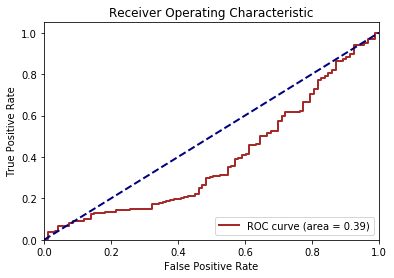

In [213]:
clustering = KMeans(random_state=0, n_clusters=5, max_iter=500)

best_roc_auc, best_fpr, best_tpr = 0, _, _
for n_c in np.arange(2, 100, 2):
    c_now = KMeans(random_state=0, n_clusters=n_c, max_iter=500, n_init=10)
    c_now.fit(train_mid_layer)
    c_test_vals = np.amin(c_now.transform(test_mid_layer), axis=1)
    roc_auc_till_now = roc_auc_score(y_test, c_test_vals)
    if (roc_auc_till_now > best_roc_auc):
        best_roc_auc = roc_auc_till_now
        best_fpr, best_tpr, _ = roc_curve(y_test, c_test_vals, pos_label=1)
        best_roc_auc = auc(best_fpr, best_tpr)
        clustering = c_now

# clustering.fit(train_mid_layer)
# print(clustering.converged_)

cluster_test_preds = clustering.predict(test_mid_layer)

print(best_roc_auc)
print(confusion_matrix(y_test, cluster_test_preds))

plt.figure()
plt.plot(best_fpr, best_tpr, color='brown', lw=2, label='ROC curve (area = %0.2f)' % best_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

0.6445639187574671
[[ 88   5]
 [195  57]]


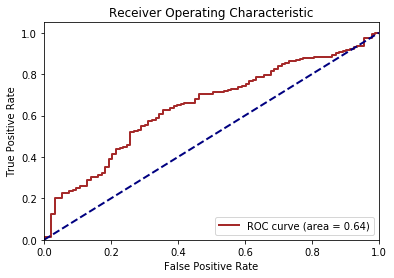

In [218]:
clustering = OneClassSVM(nu=len(y_1)/len(y_0))

best_roc_auc, best_fpr, best_tpr = 0, _, _
for kl in ('linear', 'poly', 'rbf', 'sigmoid'):
    for gm in ('auto', 'scale', 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001):
        c_now = OneClassSVM(nu=len(y_1)/len(y_0), kernel=kl, gamma=gm)
        c_now.fit(train_mid_layer)
        c_test_vals = c_now.decision_function(test_mid_layer)
        roc_auc_till_now = roc_auc_score(y_test, max(c_test_vals) - c_test_vals)
        if (roc_auc_till_now > best_roc_auc):
            best_roc_auc = roc_auc_till_now
            best_fpr, best_tpr, _ = roc_curve(y_test, max(c_test_vals) - c_test_vals, pos_label=1)
            best_roc_auc = auc(best_fpr, best_tpr)
            clustering = c_now

clustering.fit(train_mid_layer)
# print(clustering.converged_)

cluster_test_preds = clustering.predict(test_mid_layer)
cluster_test_preds[cluster_test_preds == 1] = 0
cluster_test_preds[cluster_test_preds == -1] = 1

print(best_roc_auc)
print(confusion_matrix(y_test, cluster_test_preds))

plt.figure()
plt.plot(best_fpr, best_tpr, color='brown', lw=2, label='ROC curve (area = %0.2f)' % best_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Autoencoder and OC-SVM on class=0 as training data (class=0 has NOT been changed to class=1)

for percent in np.arange(0.9, 0.01, -0.1):=

    X_0, X_1_, y_0, y_1_ = X[y==0].copy(), X[y==1].copy(), y[y==0].copy(), y[y==1].copy()
    X_1, _, y_1, _ = train_test_split(X_1_, y_1_, train_size=percent, shuffle=True, random_state=0)

    X_train, X_test_, y_train, y_test_ = train_test_split(X_0, y_0, train_size = 0.67, shuffle=True, random_state=0)
    X_test, y_test = np.concatenate((X_1.copy(), X_test_.copy())), np.concatenate((y_1.copy(), y_test_.copy()))
    X_test, y_test = shuffle(X_test, y_test, random_state=0)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = AE(hidden_size=100).to(device)
    n_epochs = 100
    model, (train_mse_list, test_1_mse_list, test_0_mse_list) = train_AE_wo_tqdm(model, X_train, y_train, X_test, y_test, to_print=False, epochs=n_epochs, print_interval=n_epochs/10)

    (train_mid_layer, test_mid_layer) = predict_middle_layer_AE(model, X_train, X_test)
    
    lof = LocalOutlierFactor(novelty=True)
    
    roc_auc_lof, fpr_lof, tpr_lof = 0, _, _
    for n_n in tqdm((1, 3, 5, 8, 10, 13, 15, 20, 30)):
        for l_s in (10, 20, 30, 40, 50):
            c_now = LocalOutlierFactor(novelty=True, n_neighbors=n_n, leaf_size=l_s)
            c_now.fit(train_mid_layer)
            c_test_vals = c_now.decision_function(test_mid_layer)
    #         c_test_vals = np.amin(c_now.kneighbors(test_mid_layer, return_distance=True)[0], axis=1)
            fpr, tpr, _ = roc_curve(y_test, max(c_test_vals) - c_test_vals, pos_label=1)
            roc_auc_till_now = auc(fpr, tpr)
            if (roc_auc_till_now > roc_auc_lof):
                roc_auc_lof = roc_auc_till_now
                fpr_lof, tpr_lof = fpr, tpr
                lof = c_now
    
    bgm = BayesianGaussianMixture(random_state=0, n_components=100)

    roc_auc_bgm, fpr_bgm, tpr_bgm = 0, _, _
    for w in tqdm(np.arange(0.001, 0.015, 0.001)):
        for wt in (0.1, 0.01, 0.001):
            c_now = BayesianGaussianMixture(random_state=0, n_components=100, weight_concentration_prior=wt)
            c_now.fit(train_mid_layer)
            c_test_vals = c_now.predict_proba(test_mid_layer)
            c_test_vals = np.amax(c_test_vals[:,(c_now.weights_ > w)], axis=1)
            fpr, tpr, _ = roc_curve(y_test, max(c_test_vals) - c_test_vals, pos_label=1)
            roc_auc_till_now = auc(fpr, tpr)
            if (roc_auc_till_now > roc_auc_bgm):
                roc_auc_bgm = roc_auc_till_now
                fpr_bgm, tpr_bgm = fpr, tpr
                bgm = c_now
                
    kmeans = KMeans(random_state=0, n_clusters=5, max_iter=500)

    roc_auc_kmeans, fpr_kmeans, tpr_kmeans = 0, _, _
    for n_c in tqdm(np.arange(2, 100, 2)):
        for random_start in range(10):
            c_now = KMeans(random_state=10*random_start, n_clusters=n_c, max_iter=500, n_init=10)
            c_now.fit(train_mid_layer)
            c_test_vals = np.amin(c_now.transform(test_mid_layer), axis=1)
            fpr, tpr, _ = roc_curve(y_test, c_test_vals, pos_label=1)
            roc_auc_till_now = auc(fpr, tpr)
            if (roc_auc_till_now > roc_auc_kmeans):
                roc_auc_kmeans = roc_auc_till_now
                fpr_kmeans, tpr_kmeans = fpr, tpr
                kmeans = c_now
                
    oc_svm = OneClassSVM(nu=len(y_1)/len(y_0))

    roc_auc_oc_svm, fpr_oc_svm, tpr_oc_svm = 0, _, _
    for kl in tqdm(('linear', 'poly', 'rbf', 'sigmoid')):
        for gm in ('auto', 'scale', 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001):
            c_now = OneClassSVM(nu=len(y_1)/len(y_0), kernel=kl, gamma=gm)
            c_now.fit(train_mid_layer)
            c_test_vals = c_now.decision_function(test_mid_layer)
            fpr, tpr, _ = roc_curve(y_test, max(c_test_vals) - c_test_vals, pos_label=1)
            roc_auc_till_now = auc(fpr, tpr)
            if (roc_auc_till_now > roc_auc_oc_svm):
                roc_auc_oc_svm = roc_auc_till_now
                fpr_oc_svm, tpr_oc_svm = fpr, tpr
                oc_svm = c_now

    plt.figure()
    plt.plot(fpr_lof, tpr_lof, color='pink', lw=2, label='ROC curve LOF (area = %0.2f)' % roc_auc_lof)
    plt.plot(fpr_bgm, tpr_bgm, color='orange', lw=2, label='ROC curve BGM (area = %0.2f)' % roc_auc_bgm)
    plt.plot(fpr_kmeans, tpr_kmeans, color='yellow', lw=2, label='ROC curve KMeans (area = %0.2f)' % roc_auc_kmeans)
    plt.plot(fpr_oc_svm, tpr_oc_svm, color='brown', lw=2, label='ROC curve OC-SVM (area = %0.2f)' % roc_auc_oc_svm)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for %0.2f' % percent)
    plt.legend(loc="lower right")
    plt.show()